# Predicting affliction severity using a convolutional neural network and dermoscopic images

Classifies scans of human skin as benign or cancerous

Dataset: <https://www.kaggle.com/datasets/sergio814/dermoscopy-images/data>

In [1]:
# Import libraries:

# Data manipulation
import numpy as np
import pandas as pd
from PIL import Image

# File management
import os
import csv
import pickle

# Neural Network architecture
from keras import utils, Input
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import load_img, img_to_array
from keras.callbacks import ModelCheckpoint

# Data visualization
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

2025-01-17 18:40:49.284352: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-17 18:40:49.527266: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737157249.619913   10613 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737157249.646111   10613 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-17 18:40:49.878056: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# File traversal & Image processing

IMAGE_DIMEN = 224 # pixel-wise size of square photos (reduced for memory)

def process_directory(base_dir, csv_filename, max_images):
    """
    Search each directory for benign and cancerous examples.
    Write the feature names as sub_pix_i for each pixel and colorspace (image_dimen * image_dimen * 3 + 1)
    Process each image and write to csv
    """
    
    benign_dir = os.path.join(base_dir, 'benign')
    cancerous_dir = os.path.join(base_dir, 'cancerous')

    # Determine the number of pixels in an image to set CSV columns
    image_shape = IMAGE_DIMEN * IMAGE_DIMEN * 3
    columns = [f'sub_pix_{i}' for i in range(image_shape)] + ['is_cancerous']

    # Open the CSV file and create a writer object
    with open(csv_filename, 'w', newline='\n') as csvfile:
        csv_writer = csv.writer(csvfile)
        
        # Write the header
        csv_writer.writerow(columns)

        # Process and write benign images
        process_and_save_images(benign_dir, False, csv_writer, max_images)
        process_and_save_images(cancerous_dir, True, csv_writer, max_images)

def process_and_save_images(directory, label, csv_writer, max_images=200):
    """
    For every file in each directory (up to a maximum image count for memory conservation)
    Load the image as a image_dimen by image_dimen size. 
    Convert to an array (break down each pixel into its R.G.B. components)
    Write that flattened array to csv (one entry is one image)
    """
    for i, filename in enumerate(os.listdir(directory)):
        if i >= max_images:
            break
        if filename.endswith('.jpg') or filename.endswith('.jpeg'):
            # Load image, resize to 224x224, flatten
            image_path = os.path.join(directory, filename)
            img = load_img(image_path, target_size=(IMAGE_DIMEN, IMAGE_DIMEN))
            img_array = img_to_array(img)
            img_array_flat = img_array.flatten()

            # Write row to CSV
            row = np.append(img_array_flat, label)
            csv_writer.writerow(row)

In [3]:
# Generate numeric values from images : save as csv and pickle

train_dir = 'data/train'
test_dir = 'data/test'

train_csv = os.path.join(train_dir, 'train_data.csv')
test_csv = os.path.join(test_dir, 'test_data.csv')

train_pkl = os.path.join(train_dir, 'train_data.pkl')
test_pkl = os.path.join(test_dir, 'test_data.pkl')

# Process directories and save to CSV if they don't exist
if not os.path.exists(train_csv):
  process_directory(train_dir, train_csv, 500) # fetch 500 benign and 500 cancerous images

if not os.path.exists(test_csv):
  process_directory(test_dir, test_csv, 200) # fetch 200 benign and 200 cancerous images

# Generate numeric csv files from image files using above methods

if not os.path.exists(train_pkl):
  print('\nLoading Training data csv : Saving as shuffled pickle\n')
  train_data = pd.read_csv(train_csv, dtype=np.uint8)
  train_data_shuffled = train_data.sample(frac=1).reset_index(drop=True)
  train_data_shuffled.to_pickle(train_pkl)

if not os.path.exists(test_pkl):
  print('\nLoading Test data csv : Saving as pickle\n')
  test_data = pd.read_csv(test_csv, dtype=np.uint8)
  test_data.to_pickle(test_pkl)

Convert csv to pickle for easier retrival (pandas struggles to load datasets with many columns, where pickle dows not)
The csv file is intended for manual inspection and debugging, while the pickle file is used by the code.
Training set is shuffled for increased model performance. An unshuffled set would overfit to the first category.
The test set does not need to be shuffled. It will be used as a prediction/reference set and will not impact model training.

In [4]:
# Fetch numeric data from pickles

def unpickle(file_path):
  with open(file_path, 'rb') as f:
    return pickle.load(f)

train_data = unpickle(train_pkl)
test_data = unpickle(test_pkl)

# Separate features and labels
train_images = train_data.drop('is_cancerous', axis=1).values
train_labels = train_data['is_cancerous'].values
test_images = test_data.drop('is_cancerous', axis=1).values
test_labels = test_data['is_cancerous'].values

# normalize the features to floats
train_images = train_images / 255.0
test_images = test_images / 255.0

# Reconstruct from flattened arrays to image_dimen by image_dimen images with 3 color dimensions
train_images = train_images.reshape(train_images.shape[0], IMAGE_DIMEN, IMAGE_DIMEN, 3)
test_images = test_images.reshape(test_images.shape[0], IMAGE_DIMEN, IMAGE_DIMEN, 3)

# Convert labels to one-hot encoding
train_labels = utils.to_categorical(train_labels, num_classes=2)
test_labels = utils.to_categorical(test_labels, num_classes=2)

In [5]:
# Initialize and train the model

# Define basic model architecture
model = Sequential([
    Input(shape=(IMAGE_DIMEN, IMAGE_DIMEN, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax') # Final layer determines 'output shape' of the model (num_classes)
])

# Compile model
model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

checkpoint = ModelCheckpoint('models/best_model.keras', 
                             monitor='val_accuracy', 
                             save_best_only=True, 
                             mode='max', 
                             verbose=1)

model.summary()

# Train the model
print('training model : this may take a few minutes') # set verbose to 1 to see more detailed training steps
history = model.fit(train_images, train_labels, epochs=50, batch_size=40, validation_split=0.2, callbacks=[], verbose=1)

W0000 00:00:1737157254.240420   10613 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 173056)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    88,605,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,662,530 (338.22 MB)

 Trainable params: 88,662,530 (338.22 MB)

 Non-trainable params: 0 (0.00 B)

training model : this may take a few minutes
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5355 - loss: 4.2043 - val_accuracy: 0.7889 - val_loss: 0.6010
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 811ms/step - accuracy: 0.6782 - loss: 0.5722 - val_accuracy: 0.2778 - val_loss: 1.0223
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 739ms/step - accuracy: 0.7344 - loss: 0.5140 - val_accuracy: 0.6944 - val_loss: 0.7013
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 735ms/step - accuracy: 0.7131 - loss: 0.5431 - val_accuracy: 0.6500 - val_loss: 0.6998
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 771ms/step - accuracy: 0.7432 - loss: 0.5179 - val_accuracy: 0.5111 - val_loss: 0.9266
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 800ms/step - accuracy: 0.7817 - loss: 0.4738 - val_accuracy: 0.1778 - val_loss: 1.0783
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 795ms/step - accuracy: 0.7655 - loss: 0.4996 - val_accuracy: 0.7056 - val_loss: 0.7177
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 771ms/step - 

# CNN Model Definitions

## Model Architecture

A sequential model is comprised of layers. The data moves linearly from first to last layer in the model construction

## Input
The number of features for the model to take in. Defined here as a 3D-Tensor, the model will take in (image_dimen x image_dimen x 3) features

## Conv2D
Convolutional layer with 64 filters, each of size (3, 3). Uses ReLU activation function. This layer detects local patterns such as edges and textures.

## MaxPooling2D
Max pooling operation for spatial data, reducing the spatial dimensions (height, width) of the input volume by taking the maximum value over a (2, 2) window. 
This helps to reduce the number of parameters and computation in the network, and also controls overfitting.

## Flatten
Converts the 2D matrix of features into a vector, making it suitable for input to a fully connected (Dense) layer.

## Dense
Fully connected layer with 512 units and ReLU activation function. This layer learns high-level features and patterns.

## Dropout
Dropout regularization technique, set to drop 50% of the neurons to prevent overfitting during training.

## Dense (Output layer)
Final fully connected layer with 2 units and softmax activation function, providing probability distribution over the classes (benign or cancerous).

## Adam Optimizer
An optimization algorithm that adjusts the learning rate during training. Adam is adaptive and computationally efficient, combining the advantages of AdaGrad and RMSProp.

## Loss function
Categorical cross-entropy is used as the loss function for classification tasks with multiple classes (in this case, two classes: benign and cancerous). 
It measures the performance of the model by comparing the predicted class probabilities with the actual class labels.

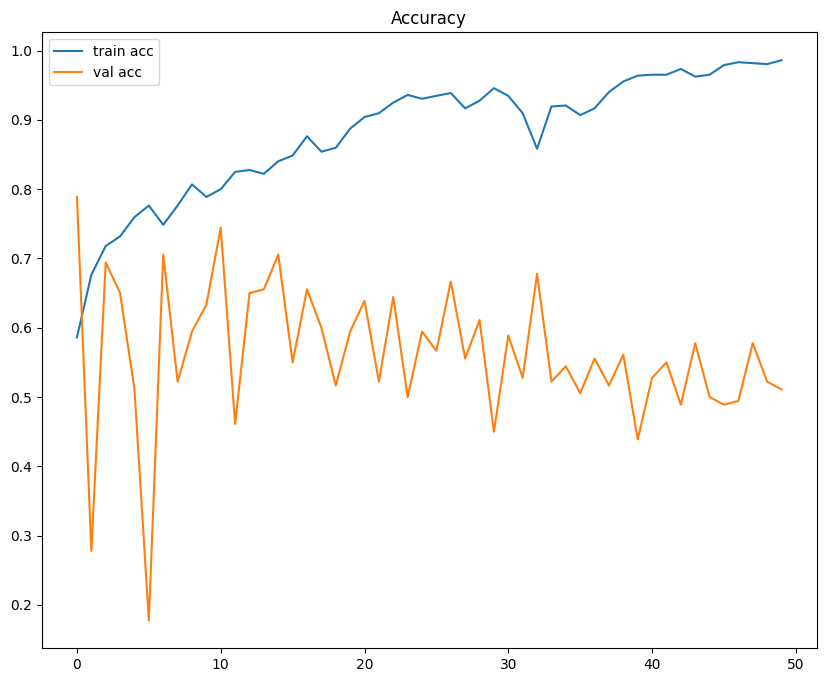

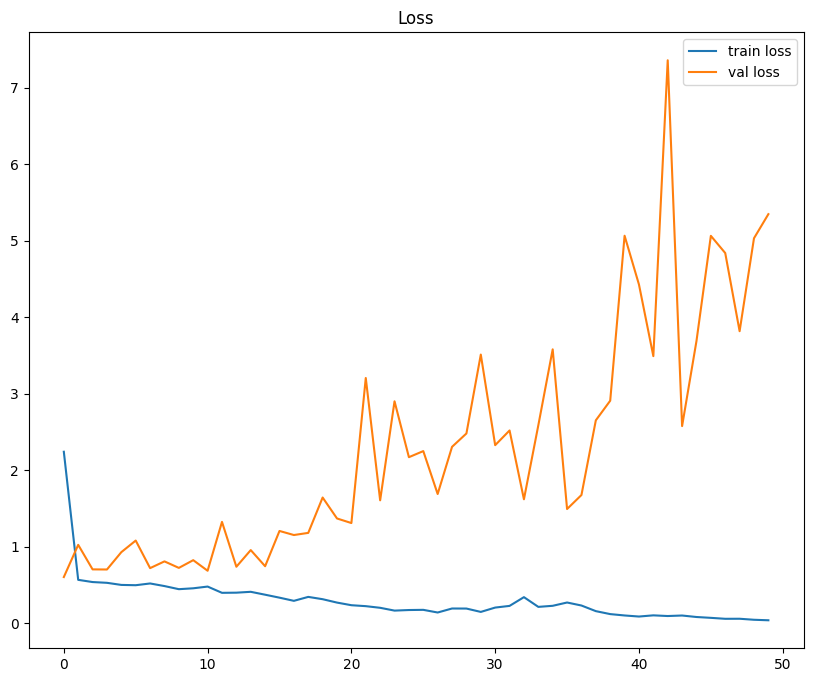

: 

In [ ]:
# accuracy plot
plt.figure(figsize=(10, 8))
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')
plt.show()
plt.close()

# loss plot
plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')
plt.show()
plt.close()

In [ ]:
# Evaluate model performance

# generate predictions
predictions = model.predict(test_images)

# Evaluate the model
_, accuracy = model.evaluate(test_images, test_labels)
print(f"Accuracy: {accuracy}")
mse = mean_squared_error(test_labels, predictions)
print(f"Mean Squared Error: {mse}")

# Obtain predictions for the test set
test_predictions = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Calculate confusion matrix for the best performing model
conf_matrix = confusion_matrix(true_labels, test_predictions, labels=[0, 1])

# Visualize confusion matrix for the best performing model
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='cividis', xticklabels=['benign', 'cancerous'], yticklabels=['benign', 'cancerous'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('CNN Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.savefig('cnn_confusion_matrix.png')
plt.show()
plt.close()

In [8]:
# model.save("models/CNN_classifier.h5")

In [9]:
# code to predict on a single image

# Load and preprocess the image
img_path = 'data/thomas_skin_sample.jpg'
img = load_img(img_path, target_size=(IMAGE_DIMEN, IMAGE_DIMEN))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize

# Make predictions on the single image
predictions = model.predict(img_array)

# predicting class probabilities
print(f"Predicted probabilities: {predictions}")

# binary classification
predicted_class = np.argmax(predictions, axis=1)
print(f"Predicted class: {predicted_class[0]}")

# interpret classes
class_labels = ['benign', 'cancerous']
print(f"Predicted label: {class_labels[predicted_class[0]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
Predicted probabilities: [[0.5649235  0.43507648]]
Predicted class: 0
Predicted label: benign
